<a href="https://colab.research.google.com/github/Florian-Dion/TP_IA/blob/main/ProjetBeatbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Projet :  Détection de sons de Beatbox

## Nom du binôme : HERZBERG Dwayne / DION Florian

L'objectif de ce TP consiste à détecter et reconnaître les différents sons de beatbox à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.


<img src="./Sons_Beatbox.png" width="800">



Vous disposez d'une base d'enregistrements de beatbox. Il faut reconnaître les 12 sons beatbox suivants :

$$\text{'cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming', }$$
$$\text{'kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse'}$$


**Source :** https://pubs.aip.org/asa/jasa/article/149/1/191/610401 \
Paroni, Annalisa, et al. *Vocal drum sounds in human beatboxing: An acoustic and articulatory exploration using electromagnetic articulography.* The Journal of the Acoustical Society of America 149.1 (2021): 191-206.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Chargement des données


Le fichier source sur lequel vous travaillez est la conversion des enregistrements audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

La matrice de données est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 13.

In [2]:
# Chargement des données à partir d'un fichier matlab .mat
import scipy.io as sio
test = sio.loadmat('2016HBXX_effets_mfcc_nodeltas_XY_nozcaPerFile_zcaX.mat')

# data = matrice des données : nombre d'enregistrements x 13 coefficients
data=test['X']
data=np.array(data)
data=data.astype('float64')
print('Dimension de la matrice des MFCC :',data.shape)

# label = Numéro correspondant à un son de beatbox associé à chaque enregistrement
label=test['Y']
label=np.ravel(label)
print('Dimension des labels', label.shape)

# liste des sons de beatbox
Nomlabel=['cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming','kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse']



Dimension de la matrice des MFCC : (341, 13)
Dimension des labels (341,)


MFCC contient 341 enregistrements d'une longueur de 13. Les enregistrements sont stockés dans la variable `data`.

Chaque enregistrement est associé à un label stockée dans la variable `label`.

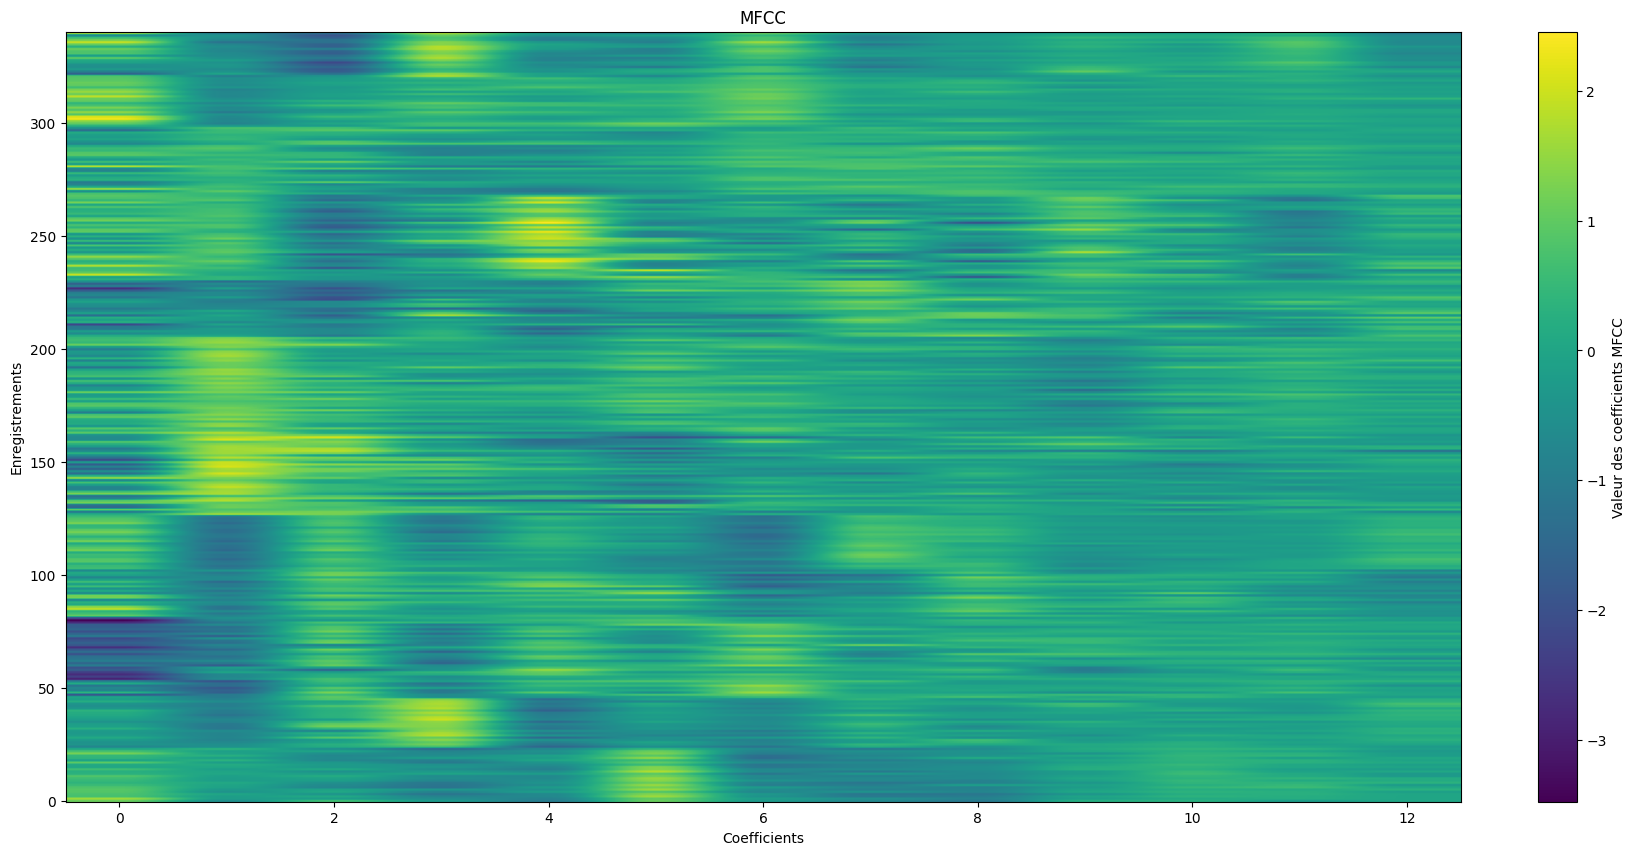

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(data, aspect='auto', origin='lower')
plt.title('MFCC')
plt.xlabel('Coefficients')
plt.ylabel('Enregistrements')
plt.colorbar(
    orientation='vertical',
    fraction=0.05,
    label='Valeur des coefficients MFCC'
)
plt.show()

Le graphique ci-dessus illutre les 12 coefficients MFCC pour chaque enregistrement audio.

In [3]:
# Description du jeu de données
unique, counts = np.unique(label, return_counts=True)


for i in range(unique.shape[0]):
    print('Label',unique[i],'correspond à ',Nomlabel[i],':',counts[i],'enregistrements');

Label 0 correspond à  cymbale_expiree : 28 enregistrements
Label 1 correspond à  cymbale_inspiree : 18 enregistrements
Label 2 correspond à  hihat_humming : 37 enregistrements
Label 3 correspond à  hihat_power ferme : 20 enregistrements
Label 4 correspond à  hihat_power ouvert : 24 enregistrements
Label 5 correspond à  kick_humming : 37 enregistrements
Label 6 correspond à  kick_power : 42 enregistrements
Label 7 correspond à  rimshot_humming : 25 enregistrements
Label 8 correspond à  rimshot_power : 38 enregistrements
Label 9 correspond à  snare_humming : 30 enregistrements
Label 10 correspond à  snare_power : 22 enregistrements
Label 11 correspond à  snare_power inverse : 20 enregistrements


###  Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisée.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

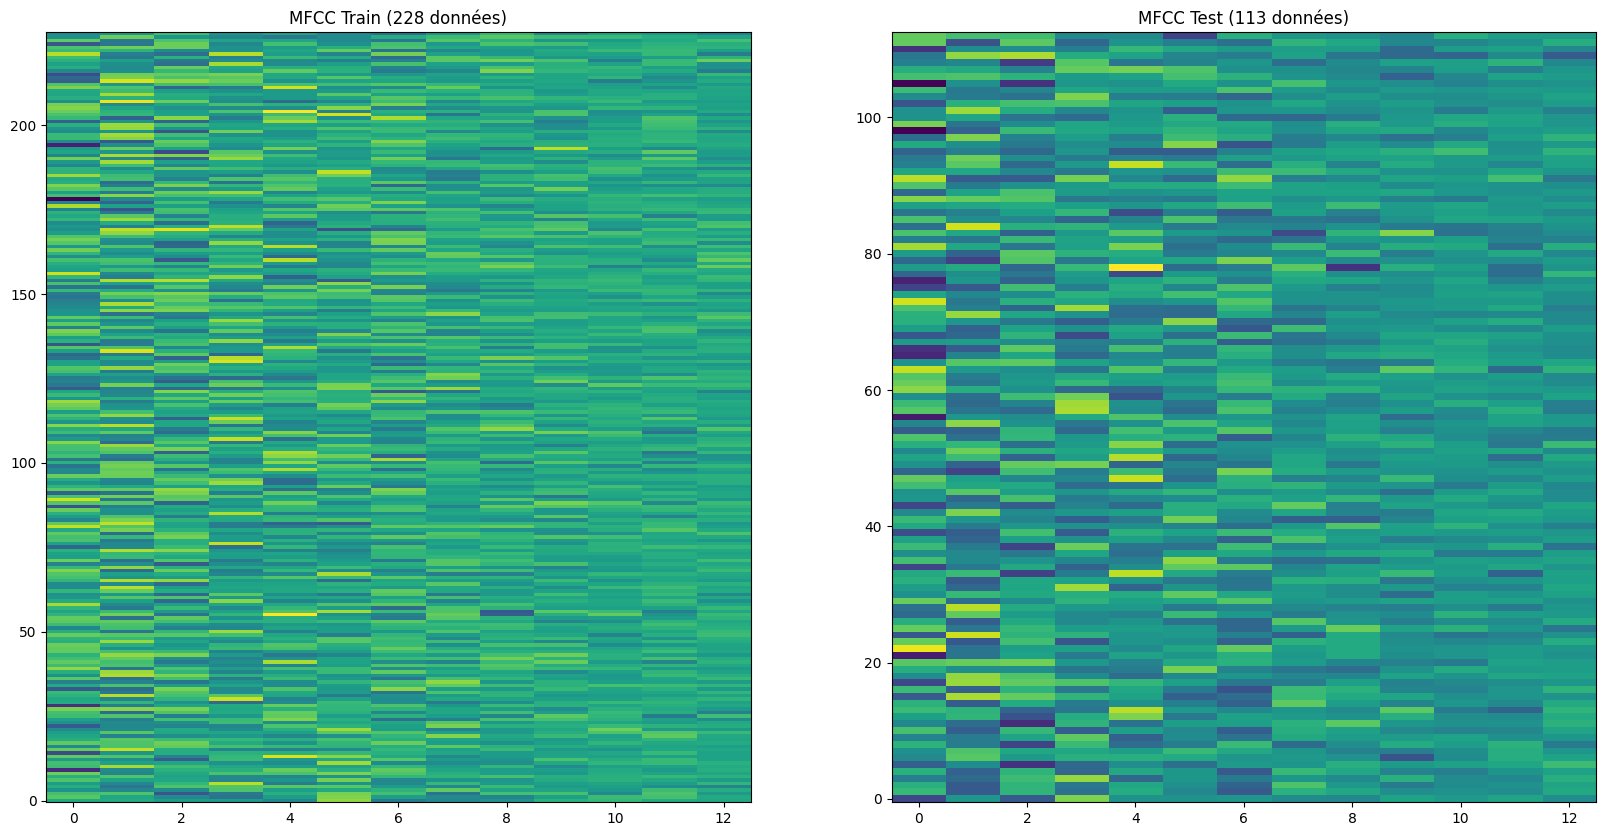

In [31]:
# afficher les données d'apprentissage et de test

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(X_train, aspect='auto', origin='lower')
plt.title('MFCC Train ({0} données)'.format(X_train.shape[0]))

plt.subplot(1,2,2)
plt.imshow(X_test, aspect='auto', origin='lower')
plt.title('MFCC Test ({0} données)'.format(X_test.shape[0]))
plt.show()

### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [23]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


# Partie I : Classification des sons beatbox sans prétraitement

Réaliser une classification de ces sons de beatbox par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser l'image des signaux présenté ci-dessus pour interpréter les résultats.

## Méthode supervisée  :
indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [24]:
from sklearn.metrics import euclidean_distances


def kppv(X_train, y_train, X_test, k):
  # X_train : données d'apprentissage
  # y_train : labels d'apprentissage
  # X_test : données de test
  # k : nombre de voisins

  # Calcul des distances entre les données de test et les données d'apprentissage
  dist = euclidean_distances(X_test, X_train)

  # Tri des indices des distances par ordre croissant
  dist_indices = np.argsort(dist)

  # Sélection des k plus proches voisins
  dist_indices_knn = dist_indices[:, 0:k]

  # Calcul des prédictions
  y_pred = np.zeros(X_test.shape[0])
  for i in range(X_test.shape[0]):
    y_pred[i] = np.bincount(y_train[dist_indices_knn[i, :].astype(int)]).argmax()

  return y_pred

# Calcul des prédictions
y_pred_kppv = kppv(X_train, y_train, X_test, 1)

# Calcul de la matrice de confusion
cm_kppv = confusion_matrix(y_test, y_pred_kppv)

# Calcul de l'accuracy
accuracy_kppv = accuracy_score(y_test, y_pred_kppv)


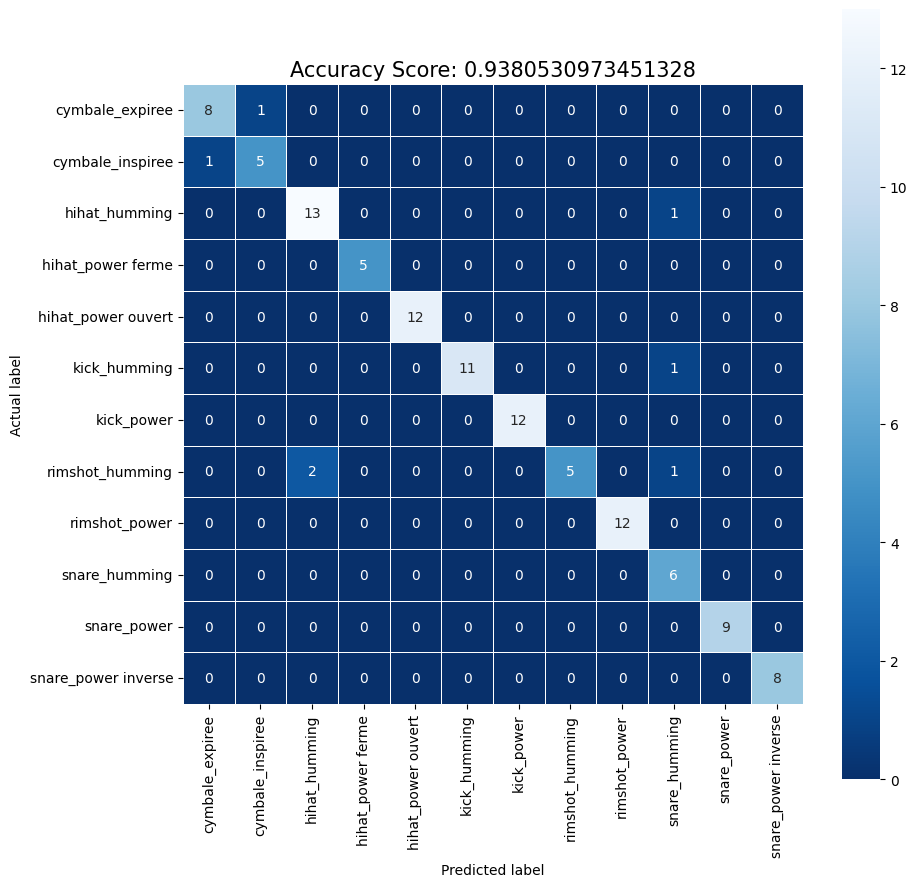

In [25]:
# Affichage de la matrice de confusion

plt.figure(figsize=(10, 10))
sns.heatmap(cm_kppv, annot=True, linewidths=.5, square=True, cmap='Blues_r', xticklabels=Nomlabel, yticklabels=Nomlabel)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_kppv)
plt.title(all_sample_title, size=15)
plt.show()

## Méthode non supervisée
Indiquer quelle est la méthode non supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [40]:
# non supervisé : clustering

from sklearn.cluster import KMeans

# Initialisation du modèle KMeans avec 12 clusters
kmeans = KMeans(n_clusters=12, random_state=0, n_init='auto')

# Apprentissage du modèle
kmeans.fit(X_train)

# Prédiction sur les données de test
y_pred_kmeans = kmeans.predict(X_test)

# Correspondance entre la partition et les classes de la vérité terrain
y_pred_kmeans = correspondance(y_pred_kmeans,y_test)

# Calcul de la matrice de confusion
cm_kmeans = confusion_matrix(y_test, y_pred_kmeans)

# Calcul de l'accuracy
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)


C:\Users\hdway\AppData\Local\Temp\ipykernel_22760\2166263020.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


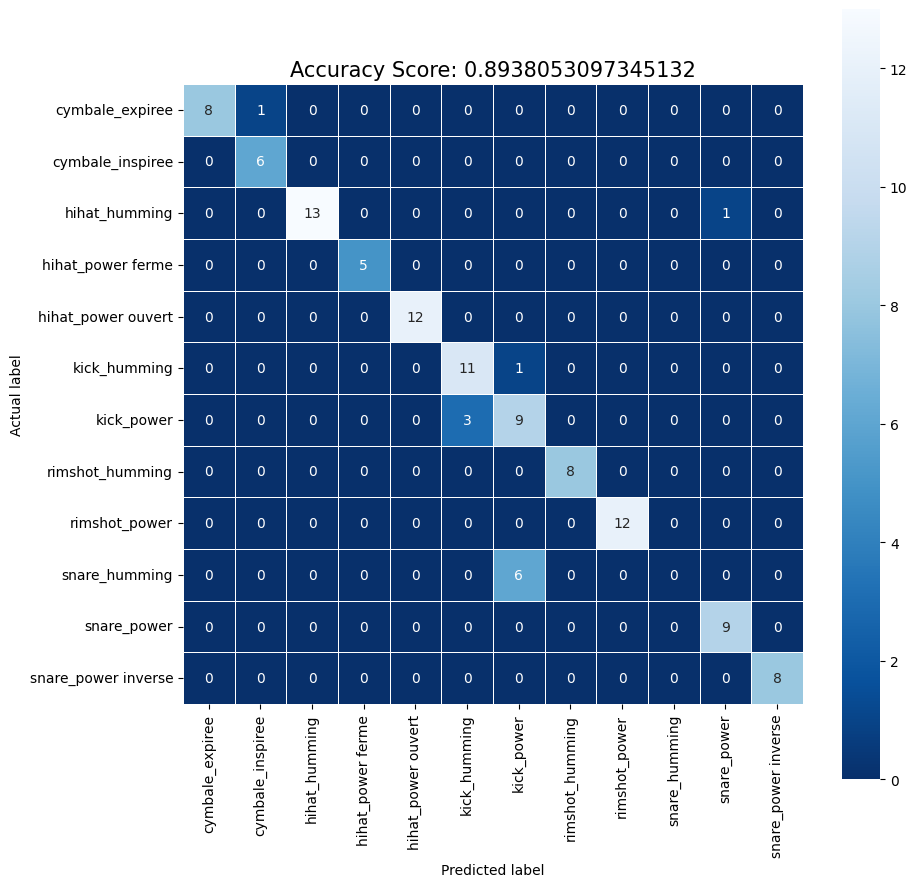

In [41]:
# Affichage de la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm_kmeans, annot=True, linewidths=.5, square=True, cmap='Blues_r', xticklabels=Nomlabel, yticklabels=Nomlabel)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_kmeans)
plt.title(all_sample_title, size=15)
plt.show()

# Partie II : Classification des sons beatbox avec prétraitement


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

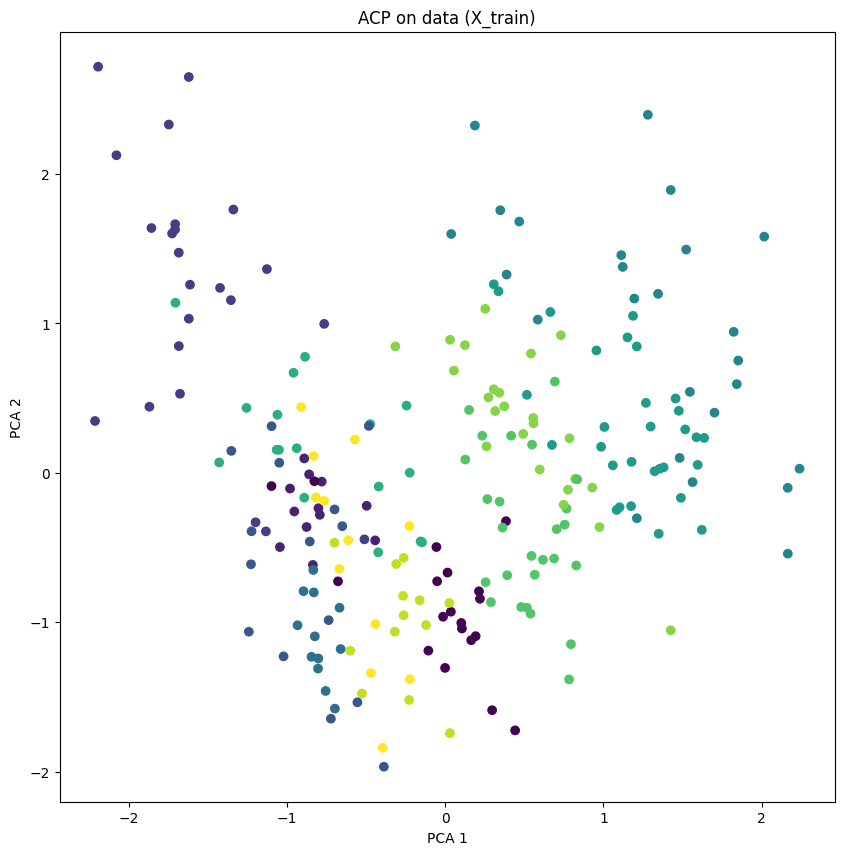

In [24]:
from sklearn.decomposition import PCA

#ACP on data (X_train)
pca = PCA(n_components=8)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

#use k-ppv on the new data
y_pred_kppv_pca = kppv(X_train_pca, y_train, pca.transform(X_test), 1)


#show the result
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('ACP on data (X_train)')
plt.show()


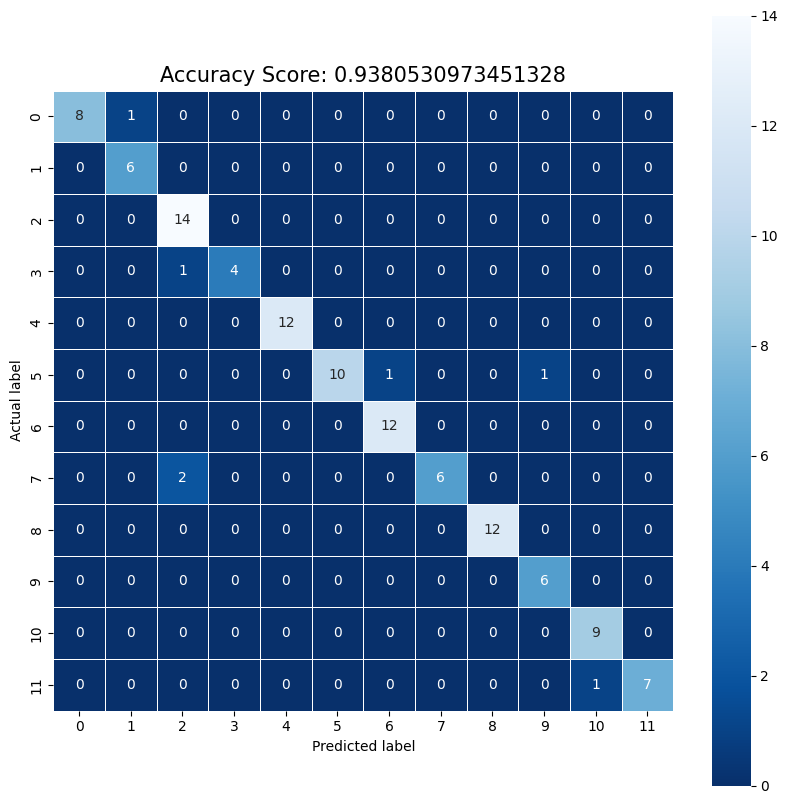

In [25]:
# Calcul de la matrice de confusion
cm_kppv_pca = confusion_matrix(y_test, y_pred_kppv_pca)
#affichage de la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm_kppv_pca, annot=True, linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred_kppv_pca))
plt.title(all_sample_title, size=15)
plt.show()



## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

# Partie III : Votre analyse


Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser l'article et les signaux présentés ci-dessus pour interpréter les résultats.

Un rapport de maximum 10 pages sera à rendre avec le notebook des codes ayant donné ces résultats.